# eCommerce Predict Repurchase 

In this project, I utilized data from an eCommerce platform __[link](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)__ to predict repurchase. The project comprises four main parts:

Part 1 - Data Exploration: This involves visualization and quality checks of the data.

Part 2 - ETL (Extract, Transform, Load): Tasks include creating a Postgres database, feature engineering, and loading data for modeling in SQL.

Part 3 - Data Preprocessing and Modeling: Utilizing techniques such as XGBoost and Random Forest to preprocess the data and build predictive models.

Part 4 - Business Recommendations: Providing actionable insights and recommendations based on the analysis and modeling results.

# Part 4  

### I used SQL to identify repurchase patterns, customer browsing behavior, and popular repurchase products 
[check SQL codes via this link](https://github.com/lulululuD/eCommerce-Project/blob/main/SQL%20part%204%20Recommendation%20SQL.sql)

# summary of my recommendation based on my SQL analysis below.
1. Analysis revealed two peak repurchase windows - within the first week after the initial purchase, and around the 30-day mark. Send targeted repurchase notifications and promotions during these high-conversion periods, specifically focusing on Sundays, Mondays, and Saturdays between 9am-4pm when repurchase activity is highest.

2. Most repurchased items were initially added to the customer's cart during their initial purchase journey. To capitalize on this behavior, implement strategies to display personalized product recommendations at the top of the cart page early in the shopping experience to encourage additional purchases before checkout.

3. Analyze purchase data to identify the most frequently repurchased items as well as items rarely repurchased. Then leverage association rules to promote item bundles that have high correlations with the top repurchased items. This cross-selling strategy can drive incremental revenue.

4. Identify the most and least popular items within each department. Then optimize inventory stocking levels to ensure high availability of top-selling products while reducing overstock of underperforming items,which improve operational efficiency.

In [63]:
import pandas as pd
from pandasql import sqldf
import numpy as np

aisles = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\aisles.csv')
departments = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\departments.csv')
order_products_prior = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\order_products_prior.csv')
order_products_train = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\order_products_train.csv')
orders = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\orders.csv')
products = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\products.csv')

## 1. How long does it take for a repurchase - 7 days and 30 days

Recommendation - send notification to those repurchase customer during the first week 

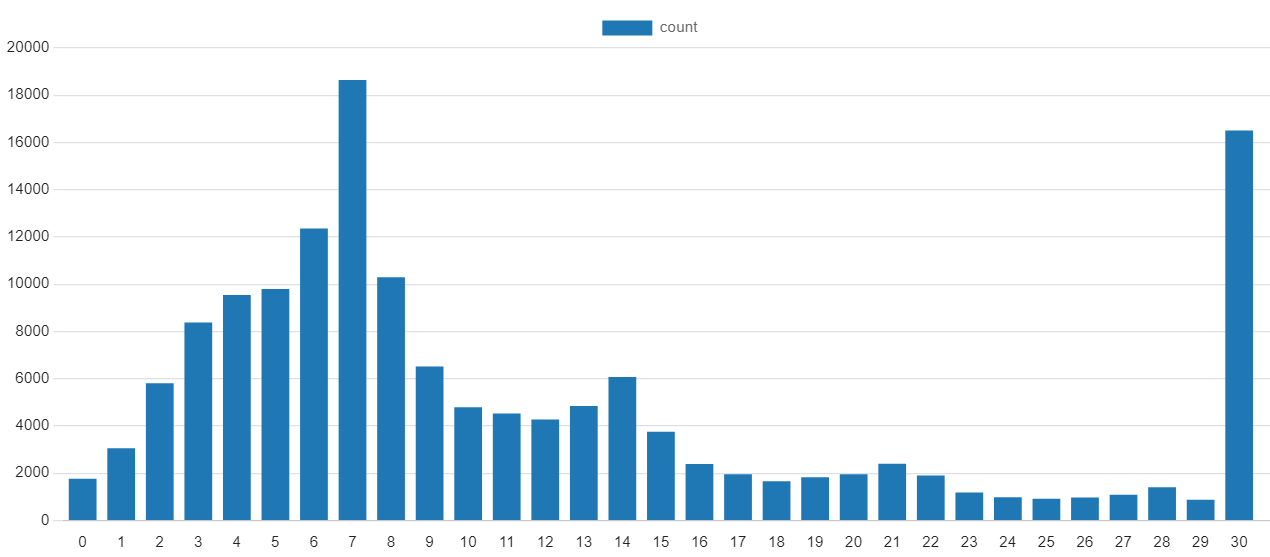

select days_since_prior_order, count(*)<br>
from "Ecommerce_Project".model_data<br>
where target = 1<br>
group by days_since_prior_order<br>

### 1.1 most repurchase happens on Sunday, followed by Monday and Saturday
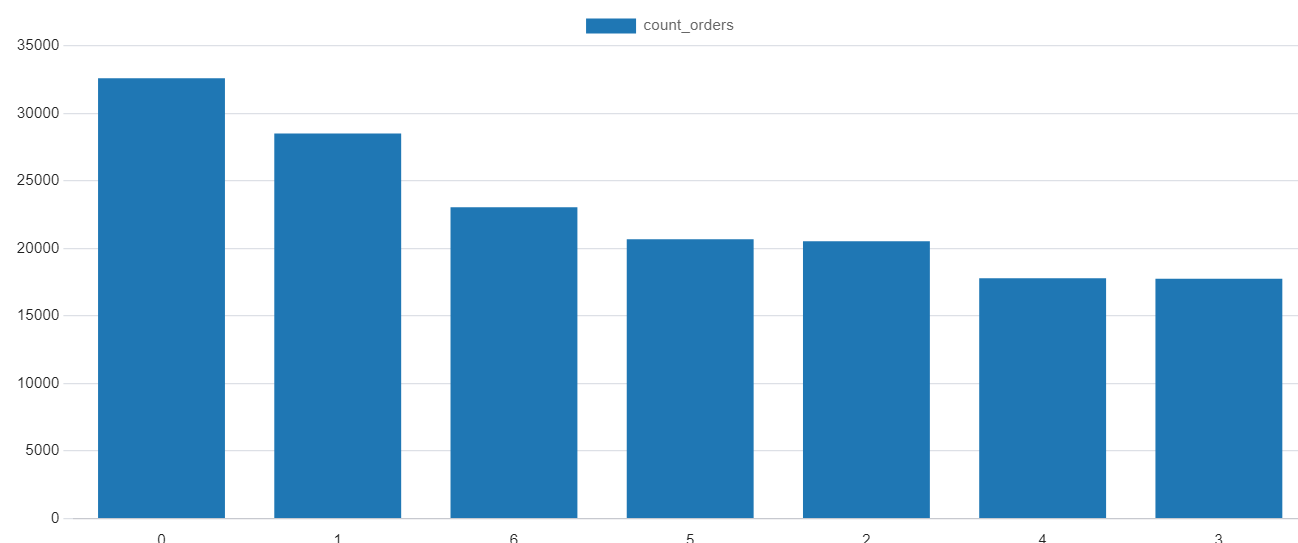


select order_dow, count(*) count_orders <br>
from "Ecommerce_Project".model_data <br>
where target = 1<br>
group by order_dow<br>
order by count_orders desc<br>

### 1.2 most repurchase happens on 9am - 4pm
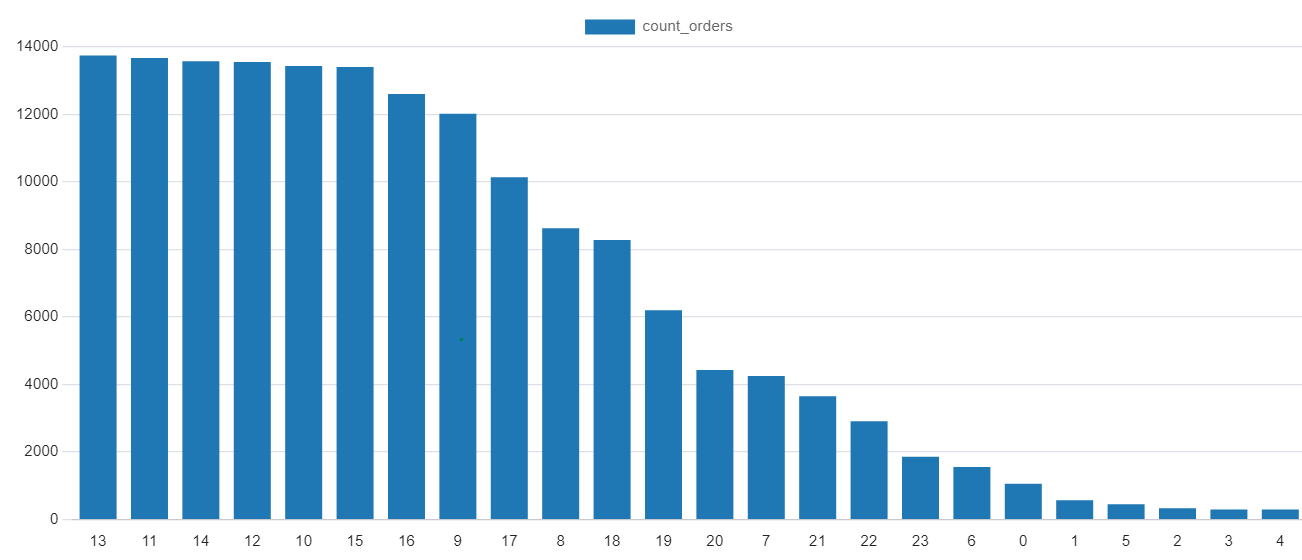
select order_hour_of_day, count(*) count_orders<br>
from "Ecommerce_Project".model_data<br>
where target = 1<br>
group by order_hour_of_day<br>
order by count_orders desc<br>

# 2.Most repurchased items are placed in cart first
Products placed 1th-7th in cart are the products mostly reordered.

recommendation - During the early stage of a customer's shopping journey, everytime he placed an item int the cart (especiallly during the first 7 items), push recommended items at the top of the cart page so that customers can pay attention during the early stage of their shopping journey and increase the chances of purchasing.

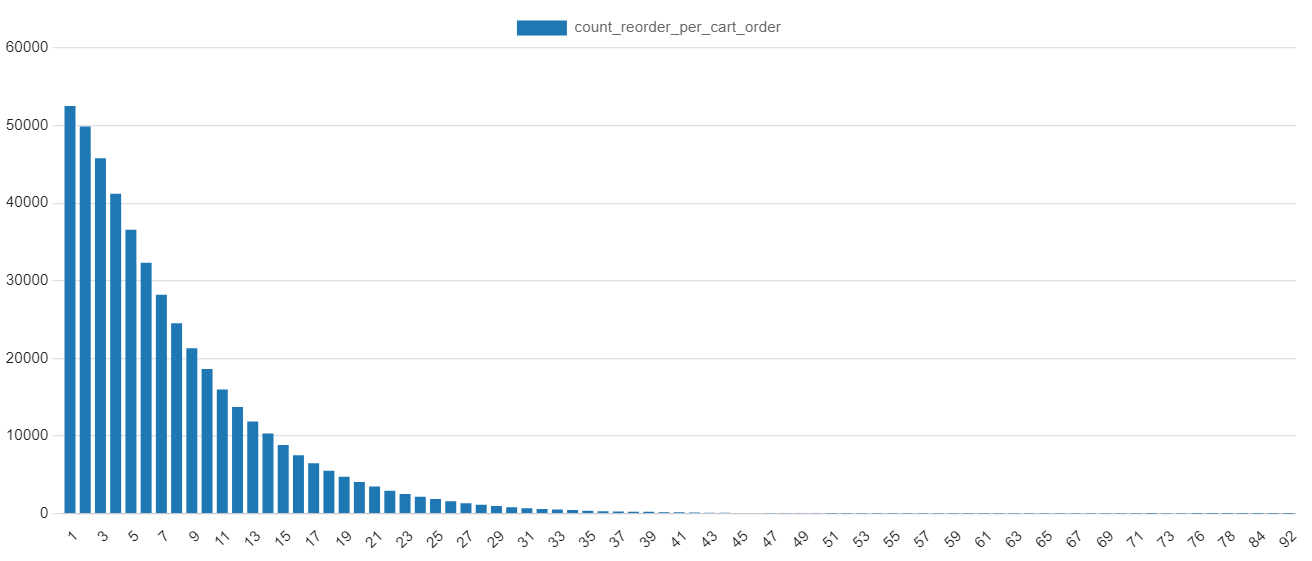

select add_to_cart_order, count(*) count_reorder_per_cart_order<br>
from "Ecommerce_Project".order_products_prior<br>
where reordered = 1<br>
group by add_to_cart_order<br>

# 3. Popular repurchaing items per department
### 3.1 most repurchased item in beverage department (example of beverage department)

recommendation - recommend items that are highly associated with the most repurchased items to increase sales. (juice & cough syrup, beer & diapers)

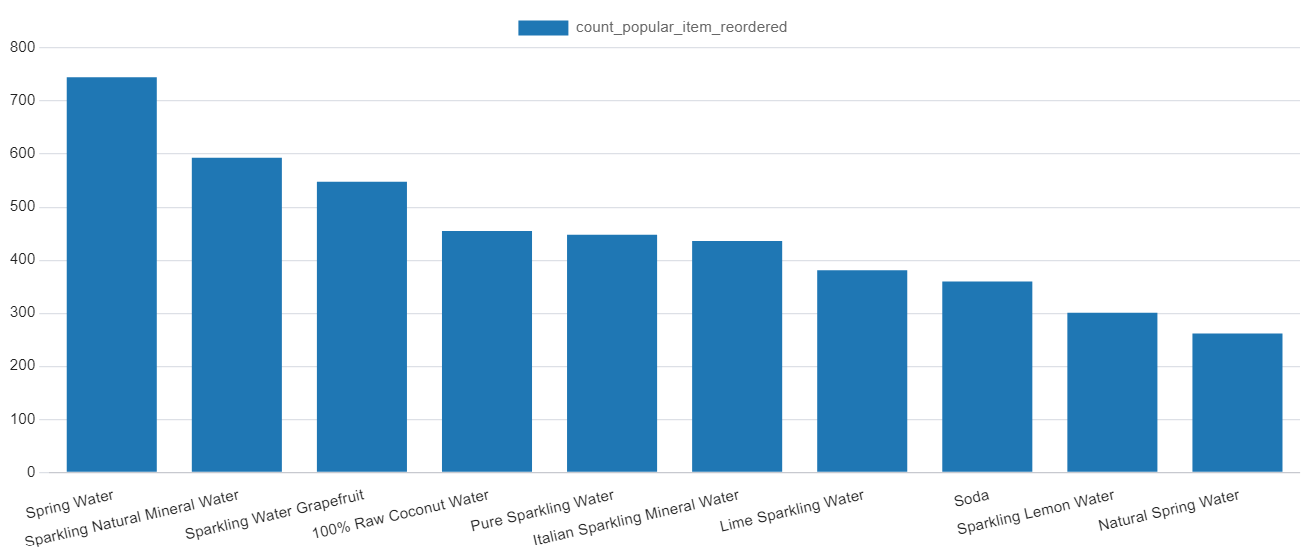

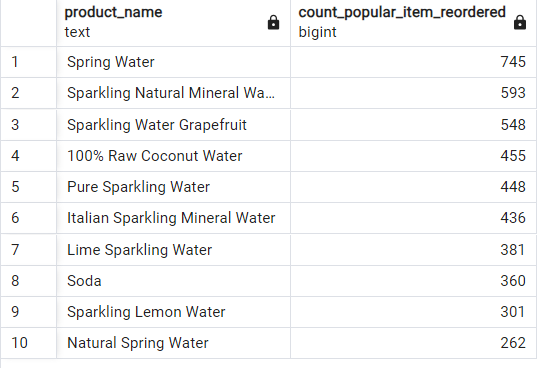


select p.product_name, count(*) count_popular_item_reordered<br>
from "Ecommerce_Project".model_data_department_product m<br>
join "Ecommerce_Project".products p<br>
on m.product_id = p.product_id<br>
where target = 1 and m.department_x = 'beverages'<br>
group by p.product_name<br>
order by count_popular_item_reordered desc<br>
limit 10<br>


### 3.2 most purchased products within each department (stock more popular items)

recommendation - stock more popular items, and run promotion of least sold items (and stock less)

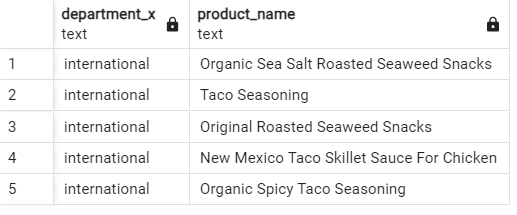

with CTE1 as (<br>
select m.department_x, p.product_name, count(*) count_orders_department_product<br>
from "Ecommerce_Project".model_data_department_product m<br>
join "Ecommerce_Project".products p<br>
on m.product_id = p.product_id<br>
group by m.department_x, p.product_name<br>
order by m.department_x<br>
)<br>
<br>
select department_x,<br>
       product_name<br>
from (select department_x,<br>
    		product_name,<br>
    		count_orders_department_product,<br>
			row_number() over (partition by department_x order by count_orders_department_product desc) rank_top5<br>
<br>
from CTE1<br>
where department_x = 'international') as tmp<br>
where rank_top5 <=5 <br>

### 3.2 Least purchased items within each department (stock more popular items)

recommendation - stock more popular items, and run promotion of least sold items (and stock less)

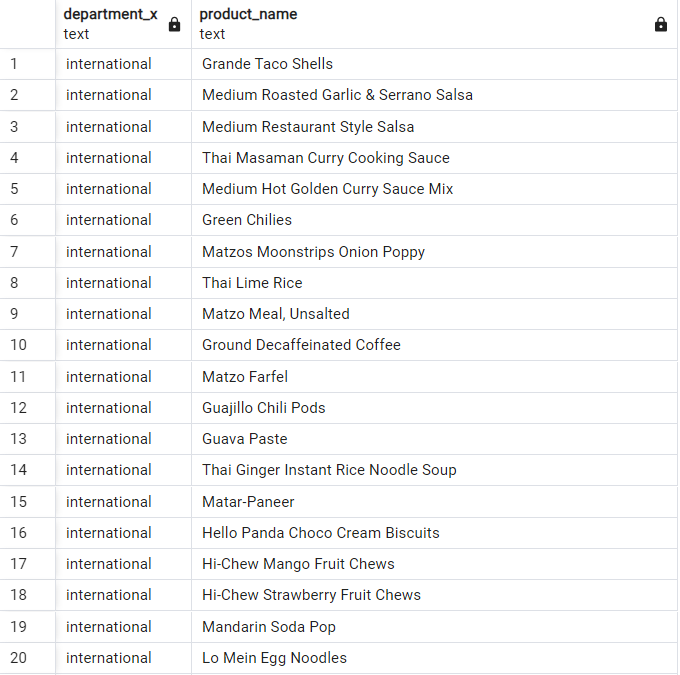

with CTE1 as (<br>
select m.department_x, p.product_name, count(*) count_orders_department_product<br>
from "Ecommerce_Project".model_data_department_product m<br>
join "Ecommerce_Project".products p<br>
on m.product_id = p.product_id<br>
group by m.department_x, p.product_name<br>
order by m.department_x<br>
)<br>
<br>
select department_x,<br>
       product_name<br>
from (select department_x,<br>
    		product_name,<br>
    		count_orders_department_product,<br>
			dense_rank() over (partition by department_x order by count_orders_department_product) rank_bottom5<br>
from CTE1<br>
where department_x = 'international') as tmp<br>
where rank_bottom5 <= 5 <br>

# 4. how many orders does it take for a repurchase
1.2% repurchase orders have 3 previous orders (max)
lots of repurchase takes 1-13 orders

recommendation- when we start to see repurchase pattern, send coupons asap


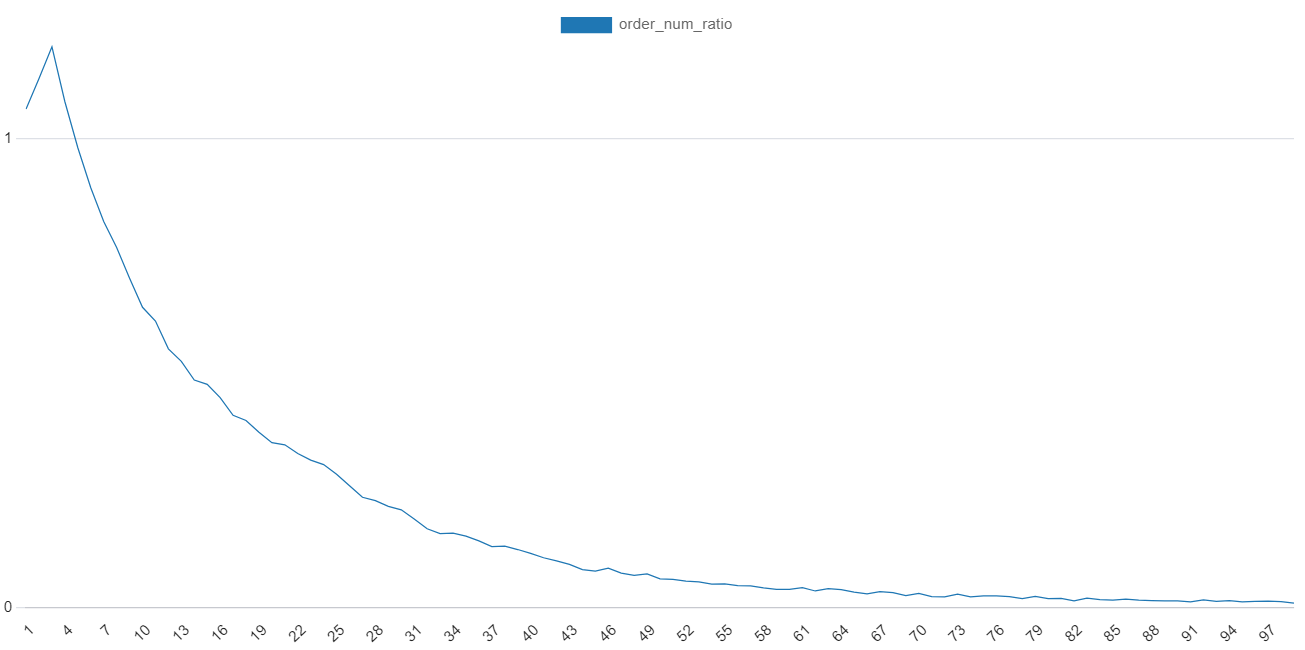

select order_number, <br>
      count( * )::float  / (select count( *) from "Ecommerce_Project".model_data) * 100 as order_num_ratio <br>
from "Ecommerce_Project".model_data <br>
where target = 1 <br>
group by order_number <br>